In [14]:
import pandas as pd
import requests
import networkx as nx
import random
from collections import Counter
import plotly.graph_objects as go
import matplotlib.pyplot as plt

In [15]:
url = "https://crowding.data.tfl.gov.uk/NUMBAT/NUMBAT%202023/NBT23FRI_outputs.xlsx"

r = requests.get(url)
with open("NBT23FRI_outputs.xlsx", "wb") as f:
    f.write(r.content)

xls = pd.ExcelFile("NBT23FRI_outputs.xlsx")
print(xls.sheet_names)

['_Cover', 'Link_Loads', 'Link_Frequencies', 'Line_Boarders', 'Station_Flows', 'Station_Entries', 'Station_Exits', 'Station_Boarders', 'Station_Alighters']


In [24]:
df_links = pd.read_excel(xls, sheet_name="Link_Loads", header=2)
df_flows = pd.read_excel(xls, sheet_name="Station_Flows", header=2)
df_entries = pd.read_excel(xls, sheet_name="Station_Entries", header=2)
df_exits = pd.read_excel(xls, sheet_name="Station_Exits", header=2)
df_boarders = pd.read_excel(xls, sheet_name="Station_Boarders", header=2)
df_alighters = pd.read_excel(xls, sheet_name="Station_Alighters", header=2)

# Extract a sorted list of interchange station names from flow data
def extract_interchange_stations(df_flows):
    interchange_rows = df_flows[df_flows["Movement"].str.contains("Interchange", na=False)]
    interchange_stations = sorted(interchange_rows["To Station"].dropna().unique())
    return interchange_stations

# Construct a directed graph where nodes are stations and edges represent flows
def build_graph_from_links(df_links, entry_stations=None, exit_stations=None):
    G = nx.DiGraph()
    for _, r in df_links.iterrows():
        # Add edge with weight = flow volume
        G.add_edge(r["From Station"], r["To Station"], weight=r["Total"])
    # Ensure all entry and exit stations are in the graph
    if len(entry_stations) > 0:
        for station in entry_stations:
            if station not in G:
                G.add_node(station)
    if len(exit_stations) > 0:
        for station in exit_stations:
            if station not in G:
                G.add_node(station)
    return G

def build_entry_weights(df_entries):
    entries = df_entries[["Station", "Total"]].dropna()
    return dict(zip(entries["Station"], entries["Total"]))

def build_exit_weights(df_exits):
    exits = df_exits[["Station", "Total"]].dropna()
    return dict(zip(exits["Station"], exits["Total"]))

# Create dictionaries for total boardings and alightings per station
def build_board_alight_dicts(df_boarders, df_alighters):
    board_dict = df_boarders.groupby("Station")["Total"].sum().to_dict()
    alight_dict = df_alighters.groupby("Station")["Total"].sum().to_dict()
    return board_dict, alight_dict

# Simulate a single route starting from a given station
# Incorporates random transfers at interchange stations and weighted moves based on flow
def simulate_route(G, start, interchange_list, board_dict, alight_dict,
                   max_steps=5, transfer_prob=0.3):
    path = [start]
    cur = start
    score = 0
    for _ in range(max_steps):
        # Possibly transfer at interchange stations based on probability
        if cur in interchange_list and random.random() < transfer_prob:
            candidates = [s for s in G.successors(cur) if s in interchange_list and s not in path]
            if candidates:
                nxt = random.choice(candidates)
                path.append(f"[TRANSFER→]{nxt}")
                cur = nxt
                continue

        if cur not in G:
            break
        succ = [s for s in G.successors(cur) if s not in path]
        if not succ:
            break
        # Choose next station based on link weights (passenger volume)
        weights = [G[cur][s]["weight"] for s in succ]
        cur = random.choices(succ, weights=weights, k=1)[0]
        path.append(cur)
        score += board_dict.get(cur, 0) + alight_dict.get(cur, 0)
    return path, score

# Run multiple route simulations and collect results
def run_simulation_pipeline(df_links, df_flows, df_entries, df_exits, df_boarders, df_alighters,
                            num_routes=10000):
    interchange_stations = extract_interchange_stations(df_flows)
    entry_stations = df_entries["Station"].dropna().unique()
    exit_stations = df_exits["Station"].dropna().unique()
    start_stations = df_entries.sort_values(by="Total", ascending=False)["Station"].tolist()
    end_stations = df_exits.sort_values(by="Total", ascending=False)["Station"].tolist()
    G = build_graph_from_links(df_links, entry_stations, exit_stations)
    entry_weights = build_entry_weights(df_entries)
    exit_weights = build_exit_weights(df_exits)
    board_dict, alight_dict = build_board_alight_dicts(df_boarders, df_alighters)

    starts = list(entry_weights.keys())
    weights = list(entry_weights.values())

    routes = []
    scores = []
    ends = []

    for _ in range(num_routes):
        start = random.choices(starts, weights=weights, k=1)[0]
        path, score = simulate_route(G, start, interchange_stations, board_dict, alight_dict)
        routes.append(path)
        scores.append(score)
        # Remove transfer tags to get clean end station
        clean_path = [step for step in path if not str(step).startswith("[TRANSFER")]
        end = clean_path[-1] if len(clean_path) >= 2 else None
        ends.append(end)

    df_result = pd.DataFrame({
        "Route": routes,
        "Score": scores,
        "End": ends
    })

    df_result["End Exit Volume"] = df_result["End"].map(exit_weights)

    df_result["Start"] = df_result["Route"].apply(lambda x: x[0] if len(x) > 0 else None)
    df_result["End Clean"] = df_result["End"]
    df_result = df_result[df_result["Start"].isin(start_stations) & df_result["End Clean"].isin(end_stations)]

    return df_result

def plot_route_pair_frequencies(df_result):
    # Create a combined Start-End key for each route
    df_result["Route_Pair"] = df_result["Start"] + " → " + df_result["End Clean"]

    # Count frequency of each unique Start-End pair
    pair_counts = df_result["Route_Pair"].value_counts().reset_index()
    pair_counts.columns = ["Route_Pair", "Count"]

    # Sort by frequency descending
    pair_counts = pair_counts.sort_values(by="Count", ascending=False).reset_index(drop=True)

    # Plot the frequencies as a line chart
    plt.figure(figsize=(14, 6))
    plt.plot(range(len(pair_counts)), pair_counts["Count"], marker='o', linewidth=1.5)
    plt.title("Frequency of Simulated Start-End Route Pairs", fontsize=14)
    plt.xlabel("Route Pair Rank (sorted by frequency)", fontsize=12)
    plt.ylabel("Number of Simulated Occurrences", fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

def plot_cumulative_route_distribution(df_result, top_k_lines=[10, 50, 100]):
    df_result["Route_Pair"] = df_result["Start"] + " → " + df_result["End Clean"]
    pair_counts = df_result["Route_Pair"].value_counts()

    total = pair_counts.sum()
    cumulative = pair_counts.cumsum() / total

    plt.figure(figsize=(12, 6))
    plt.plot(range(1, len(cumulative)+1), cumulative.values, marker='.', linewidth=2)
    plt.xlabel("Route Pair Rank (sorted by frequency)", fontsize=12)
    plt.ylabel("Cumulative Share of Simulated Routes", fontsize=12)
    plt.title("Cumulative Distribution of Start-End Route Pair Frequencies", fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.6)

    for k in top_k_lines:
        if k <= len(cumulative):
            plt.axvline(k, color='gray', linestyle=':', alpha=0.7)
            plt.text(k, cumulative.values[k-1] + 0.02, f"Top {k}: {cumulative.values[k-1]*100:.1f}%", 
                     ha='right', fontsize=10, color='black')

    plt.ylim(0, 1.05)
    plt.tight_layout()
    plt.show()

To capture the variability and distribution of possible travel routes in a realistic manner, we employed a Monte Carlo simulation approach. A total of 30,000 simulation runs were conducted. This number was selected as a balance between computational efficiency and statistical robustness.
  
According to the law of large numbers and the central limit theorem, the accuracy of Monte Carlo estimates improves at a rate of O(1/N^(1/2)), where N is the number of samples. In practical terms, increasing the number of runs from 10,000 to 30,000 reduces the expected standard error by approximately 42%, which significantly improves the stability of the estimated route frequency distribution without incurring excessive computational cost.
  
Furthermore, as discussed in Glasserman (2004) and Rubinstein & Kroese (2016), simulation sizes in the range of 10,000 to 100,000 are typically sufficient for modeling aggregate behaviors in large-scale stochastic systems, such as transportation networks. Therefore, we consider 30,000 simulations appropriate for capturing the dominant patterns in route choices and interchange behaviors within our data-driven model.
  
_References:_  
_Glasserman, P. (2003). Monte Carlo Methods in Financial Engineering. Springer_  
_Rubinstein, R. Y., & Kroese, D. P. (2016). Simulation and the Monte Carlo Method (3rd ed.). Wiley_

In [ ]:
df_result = run_simulation_pipeline(
    df_links, df_flows, df_entries, df_exits,
    df_boarders, df_alighters,
    num_routes = 30000
    )

d:\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:2062: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.

d:\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:250: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.



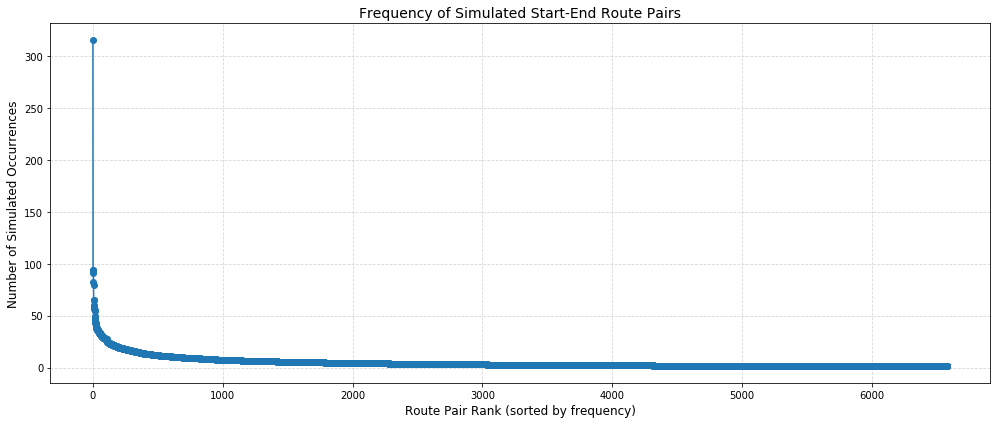

In [26]:
plot_route_pair_frequencies(df_result)

In order to identify the most representative and frequently used travel patterns from the Monte Carlo simulation, we define a route pair (start-end) as a popular route if it appeared 25 times or more among the 30,000 simulated journeys. This threshold was chosen based on the long-tailed distribution of route frequencies (see the figure above),  while a relatively small subset accumulates significantly higher counts.
  
By selecting a cutoff at 25 occurrences, we strike a balance between statistical significance and data coverage: the selected route pairs are not only sufficiently frequent to reflect recurring patterns, but also limited in number to allow focused downstream analysis. This approach helps avoid over-interpreting extremely rare, potentially random route combinations, and instead centers the analysis on routes that consistently emerge in the simulated travel behavior.

In [30]:
def count_frequent_route_pairs(df_result, min_occurrence=25):
    df_result["Route_Pair"] = df_result["Start"] + " → " + df_result["End Clean"]
    pair_counts = df_result["Route_Pair"].value_counts()
    frequent_pairs = pair_counts[pair_counts >= min_occurrence]
    print(f"Number of route pairs that occurred ≥ {min_occurrence} times: {len(frequent_pairs)}")
    return frequent_pairs

frequent_pairs = count_frequent_route_pairs(df_result, min_occurrence = 25)

Number of route pairs that occurred ≥ 25 times: 119


In [ ]:
def save_frequent_route_pairs_split(df_result, min_occurrence = 25, filename = "frequent_routes.csv"):
    df_result["Route_Pair"] = df_result["Start"] + " → " + df_result["End Clean"]
    pair_counts = df_result["Route_Pair"].value_counts()

    frequent_pairs = pair_counts[pair_counts >= min_occurrence].reset_index()
    frequent_pairs.columns = ["Route_Pair", "Count"]
    frequent_pairs[["Start_Station", "End_Station"]] = frequent_pairs["Route_Pair"].str.split(" → ", expand=True)
  
    output_df = frequent_pairs[["Start_Station", "End_Station", "Count"]]
    output_df.to_csv(filename, index=False)
    
    print(f"Saved {len(output_df)} frequent route pairs to '{filename}'")
    return output_df

save_frequent_route_pairs_split(df_result, min_occurrence = 25, filename = "frequent_routes.csv")

Saved 119 frequent route pairs to 'frequent_routes.csv'


,Start_Station,End_Station,Count
0,Wimbledon,Parsons Green,316
1,Euston NR,Willesden Junction,94
2,Morden,Balham LU,94
3,Tooting Broadway,Clapham North,91
4,Barking,Elm Park,82
...,...,...,...
114,Waterloo LU,Oxford Circus,25
115,Slough,Southall,25
116,Beckton,Prince Regent,25
117,Leytonstone,Barkingside,25
